# **ONLINE RETAIL CLEANING AND ANALYSIS**

Import the required libraries and load the dataset combined

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
df = pd.read_csv("../data/raw/online_retail_combined.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1. Drop duplicates
Delete the duplicates records of the dataset to start the cleaning process

In [138]:
df.duplicated().sum()

np.int64(34335)

In [139]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

## 2. Imputing missing values
Analyze the columns with missing values and determine the best way to impute them.

In [140]:
print(df.isnull().sum().sort_values(ascending=False))

Customer ID    235151
Description      4275
StockCode           0
Invoice             0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64


The CUSTOMER ID column is not relevant to the analysis in this context, the best option to impute these values is replace with
a word or text to identify them. Also, we must change the data type of this column to object.

In [141]:
df['Customer ID'] = df['Customer ID'].fillna('Unknown').apply(lambda x: str(int(x)) if isinstance(x, float) else str(x))

The Description column is a special case. First, we can use the StockCode to try to fill the missing values with the corresponding description found in other rows with the same code. If there are still null values after that, we can replace 
them with a generic word to represent the missing field without affecting the analysis.

In [142]:
# Create dictionary to save the description and stock code without null values
stockcode = df.dropna(subset=["Description"]).drop_duplicates("StockCode").set_index("StockCode")["Description"].to_dict()

# Impute missing values in the DataFrame using the dictionary
df["Description"] = df.apply(
    lambda row: stockcode[row["StockCode"]] if pd.isna(row["Description"]) and row["StockCode"] in stockcode else row["Description"],
    axis=1
)
df["Description"].isna().sum()

np.int64(363)

Before the first step, there were 4,382 missing values in the Description column. After imputing values using the dictionary, only 363 missing values remained. This approach helps preserve most of the data. Finally, we can replace the remaining missing values with the generic term "Unknown" to complete the imputation process.

In [143]:
df["Description"] = df["Description"].fillna("Unknown")
df["Description"].isna().sum()

np.int64(0)

In this way, we obtain a fully imputed dataset and can proceed with the final steps of the cleaning process.

In [144]:
print(df.isnull().sum().sort_values(ascending=False))

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


## 3. Split the columns to ease the analysis
The column Invoice contains values that start with a letter ("C") to indicate canceled transactions. This column may need to be split for better analysis. 
For the completed transaction, we use "F" to complete the column information.

In [145]:
# Extract the Prefix and create the new column
df["TransactionStatus"] = df["Invoice"].str.extract(r'^([A-Za-z])')

# Replace de new missing values and replace with "F" for the completed transactions
df["TransactionStatus"] = df["TransactionStatus"].fillna("F")

# Drop the characters without delete the number Invoice
df["Invoice"] = df["Invoice"].str.replace(r"[A-Za-z]", "", regex=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,F
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,F
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,F
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,F
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,F


Finally, we can split the InvoiceDate column to extract the month and the year separately. First, transform the data type to datetime and after, create the new columns: MonthInvoice and YearInvoice.

In [146]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['MonthInvoice'] = df['InvoiceDate'].dt.month
df['YearInvoice'] = df['InvoiceDate'].dt.year

The last column we need to add to the dataset is the total sales, calculated as the product of quantity and price.
The final dataset with the new columns looks like this.

In [147]:
df['TotalSales'] = df['Quantity']*df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus,MonthInvoice,YearInvoice,TotalSales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,F,12,2009,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,F,12,2009,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,F,12,2009,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,F,12,2009,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,F,12,2009,30.0


Save the data cleaned and transformed in a CSV file.

In [148]:
df.to_csv('../data/cleaned/online_retail_cleaned.csv', index=False)

## 4. Data analysis
Once the transformation process was done, start with the analysis stage.
First, we want to know which is the country with the highest sales on the dates recorded in the table.
The analysis was made for the top 10 sales by country because there are many countries and the information would not be clear.

In [149]:
top10_countries = (df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False).head(10).index)
df_top10sales = df[df['Country'].isin(top10_countries)]
df_top10sales['Year'] = df_top10sales['InvoiceDate'].dt.year
df_top10sales['Month'] = df_top10sales['InvoiceDate'].dt.month

C:\Users\Win10L\AppData\Local\Temp\ipykernel_17080\1719832426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10sales['Year'] = df_top10sales['InvoiceDate'].dt.year
C:\Users\Win10L\AppData\Local\Temp\ipykernel_17080\1719832426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10sales['Month'] = df_top10sales['InvoiceDate'].dt.month


In [150]:
monthly_sales = df_top10sales.groupby(['Country','Year', 'Month'])['TotalSales'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str))
monthly_sales.head()

,Country,Year,Month,TotalSales,Date
0,Australia,2009,12,50.25,2009-12-01
1,Australia,2010,2,1029.66,2010-02-01
2,Australia,2010,3,429.39,2010-03-01
3,Australia,2010,4,630.95,2010-04-01
4,Australia,2010,5,1312.70,2010-05-01


In [151]:
df_top10countrysales = df_top10sales.groupby(['Country'])['TotalSales'].sum().sort_values(ascending=False).reset_index()
df_top10countrysales

,Country,TotalSales
0,United Kingdom,1.598606e+07
1,EIRE,6.099538e+05
2,Netherlands,5.483307e+05
3,Germany,4.119592e+05
4,France,3.217334e+05
5,Australia,1.664444e+05
6,Switzerland,9.940306e+04
7,Spain,9.101344e+04
8,Sweden,8.777552e+04
9,Denmark,6.445959e+04


As we can see, sales in the United Kingdom are much higher than in other countries, so they will be analyzed separately to more clearly visualize the comparison between other countries.

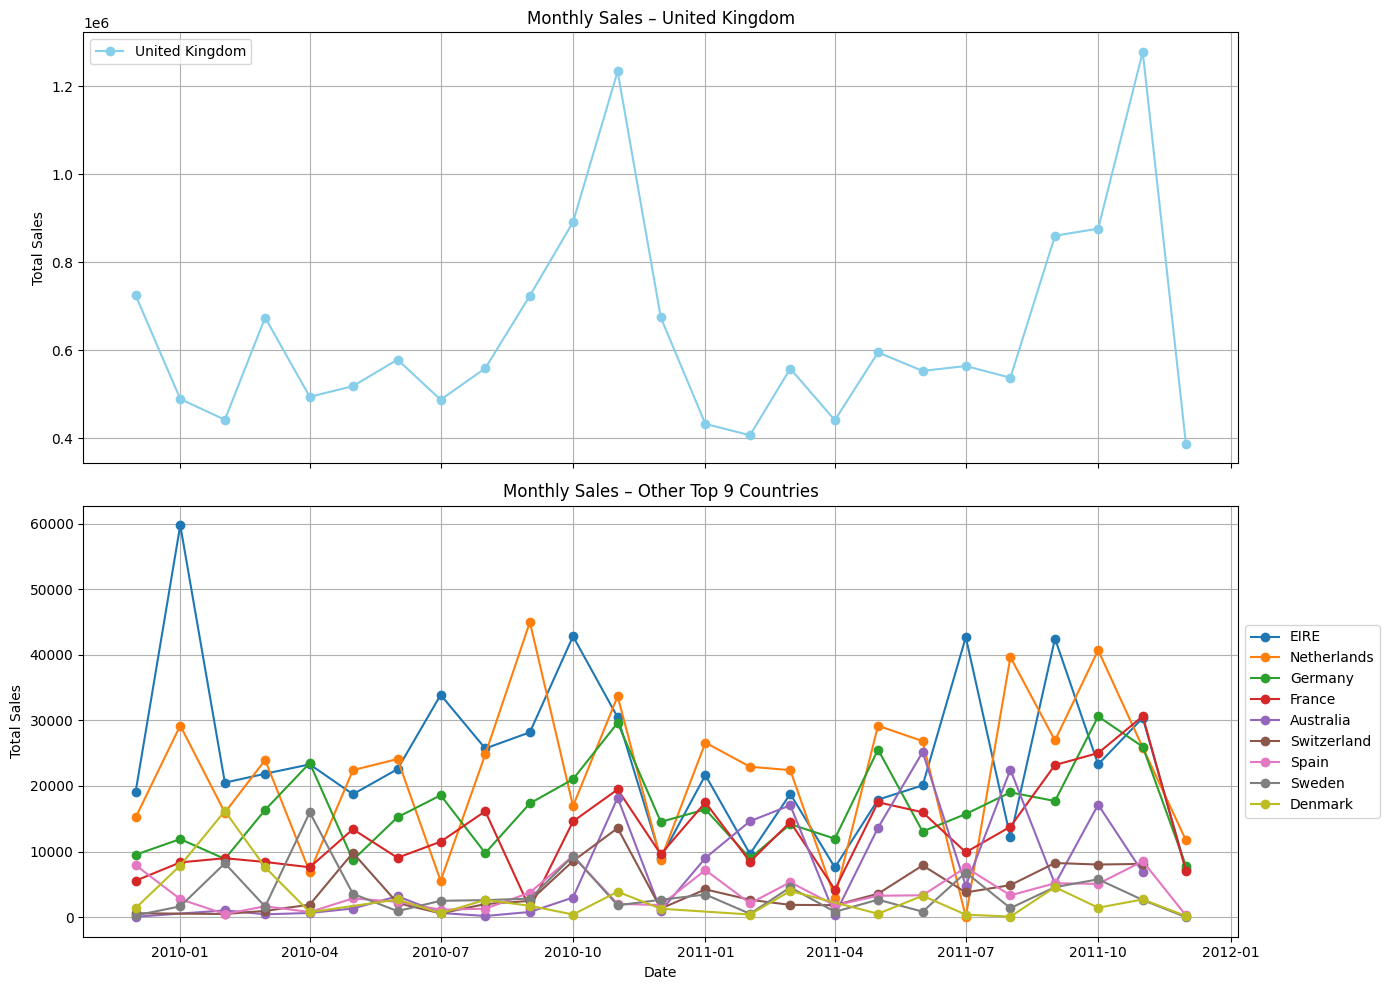

In [152]:
df_uk = monthly_sales[monthly_sales['Country'] == 'United Kingdom']
df_others = monthly_sales[monthly_sales['Country'] != 'United Kingdom']

sorted_countries = df_others.groupby('Country')['TotalSales'].sum().sort_values(ascending=False).index

# United Kingdom
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df_uk['Date'], df_uk['TotalSales'], marker='o', color='skyblue', label='United Kingdom')
axes[0].set_title('Monthly Sales – United Kingdom')
axes[0].set_ylabel('Total Sales')
axes[0].legend()
axes[0].grid(True)

# Other top 9 countries
for country in sorted_countries:
    data = df_others[df_others['Country'] == country]
    axes[1].plot(data['Date'], data['TotalSales'], marker='o', label=country)

axes[1].set_title('Monthly Sales – Other Top 9 Countries')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Sales')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True)

plt.tight_layout()
plt.show()


Reviewing the graphs, we can conclude that the United Kingdom is far ahead of the other countries.
The top 2 (EIRE-Ireland) and the top 3 (Netherlands) are performing better than the others.
Additionally, we found a pattern, although it's difficult because only two years were analyzed.
The highest sales were recorded between October and November of both years. This is the best sales season in general; it can be leveraged to get more out of it during this time of year.

Now we are going to analyze the country with the most sales since it indicates that the largest amount of data is in this part of the data set.
In this case we are going to look for the best-selling products per month in the United Kingdom.

In [ ]:
df_uk = df[df['Country']=='United Kingdom']
top5_productsUK = (df_uk.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5).index)
top_productsUK = df_uk[df_uk['Description'].isin(top5_productsUK)]
top_productsUK['Year'] = top_productsUK['InvoiceDate'].dt.year
top_productsUK['Month'] = top_productsUK['InvoiceDate'].dt.month

monthly_products = (top_productsUK.groupby(['Description','Year','Month'])['Quantity'].sum().reset_index())
monthly_products['Date'] = pd.to_datetime(monthly_products['Year'].astype(str) + '-' + monthly_products['Month'].astype(str))

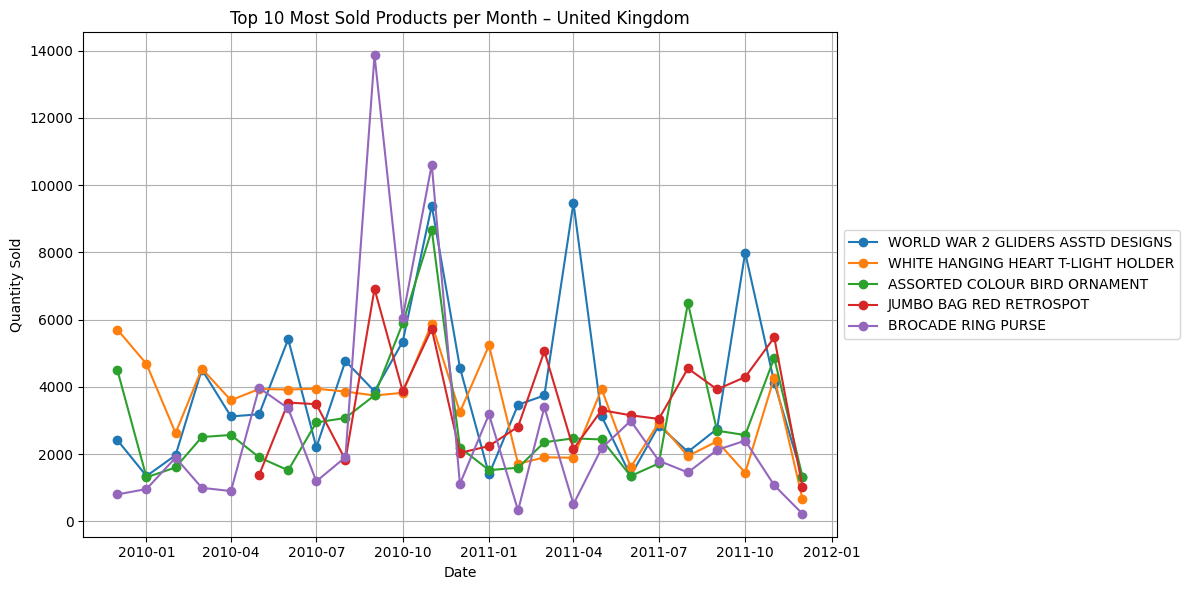

In [154]:
plt.figure(figsize=(12, 6))

for product in top5_productsUK:
    data = monthly_products[monthly_products['Description'] == product]
    plt.plot(data['Date'], data['Quantity'], marker='o', label=product)
plt.title('Top 10 Most Sold Products per Month – United Kingdom')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In the graph, we can observe the behavior of the top 5 products sold in the United Kingdom. The top product is World War 2 Gliders, although Brocade Ring Purse shows a strange pattern with a few spikes but very low sales during the rest of the year.
These trends are important to analyze, as they help the marketing department design strategies or plans to increase or stabilize sales throughout the year.

Finally, we can analyze the customers more important to the company in United Kingdom searching the top - sales by month, and reviewing behavior and determining if it is periodic or seasonal.

In [ ]:
df_uk = df[df['Country']=='United Kingdom']
df_uk = df_uk[df_uk['Customer ID'] != 'Unknown']
top5_customerUK = (df_uk.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(5).index)
top_customerUK = df_uk[df_uk['Customer ID'].isin(top5_customerUK)]
top_customerUK['Year'] = top_customerUK['InvoiceDate'].dt.year
top_customerUK['Month'] = top_customerUK['InvoiceDate'].dt.month

monthly_customer = (top_customerUK.groupby(['Customer ID','Year','Month'])['Quantity'].sum().reset_index())
monthly_customer['Date'] = pd.to_datetime(monthly_customer['Year'].astype(str) + '-' + monthly_customer['Month'].astype(str))

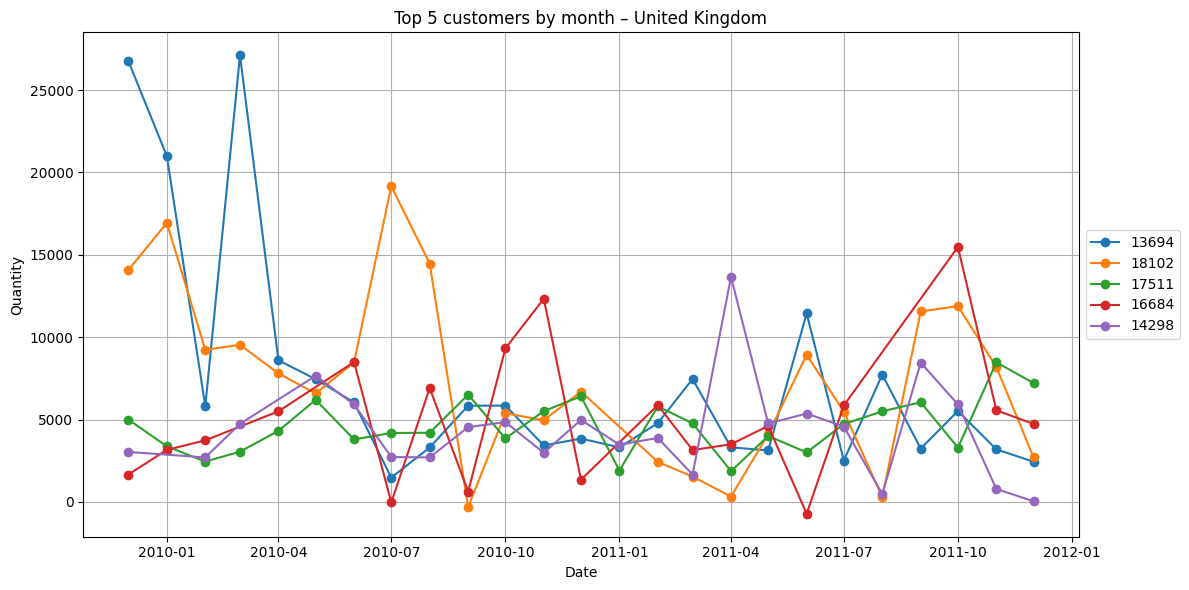

In [156]:
plt.figure(figsize=(12, 6))

for customer in top5_customerUK:
    data = monthly_customer[monthly_customer['Customer ID'] == customer]
    plt.plot(data['Date'], data['Quantity'], marker='o', label=customer)
plt.title('Top 5 customers by month – United Kingdom')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The top 5 clients per month chart shows similar behavior for some of them. Clients '13694' and '18102' display noticeable peaks throughout the year. Although the dataset does not cover many years, no consistent trend is observed over time.
It appears that these customers purchase based on need rather than seasonality.
Another important aspect is the presence of negative values. We can see that in some months, the accumulated quantity is negative, indicating that the data includes product returns, which in those cases exceeded the total sales for the month.

## 6. Conclusions

Throughout the cleaning and analysis process, several important patterns and insights were identified:

- **United Kingdom** is the most dominant market in terms of total sales. Its sales show a strong seasonal trend, peaking consistently in the months of **October and November**. This pattern suggests higher consumer demand during the holiday season and could be used to guide promotional planning.

- When focusing on the **top 5 clients** in the UK, we noticed that some clients, such as *Customer 13694* and *Customer 18102*, exhibit irregular purchasing behavior with noticeable peaks in specific months. No consistent monthly trend was found, indicating that purchases are more likely based on need rather than seasonality.

- A significant issue uncovered during the analysis is the presence of **negative sales values**, particularly in the `Quantity` column. These values correspond to **product returns**, and in some months, the volume of returned products was greater than the sales — resulting in negative totals. This confirms that the dataset includes cancellations or refund transactions.

- These findings are crucial from a business perspective. Returns can impact revenue stability and may indicate issues with product quality, customer satisfaction, or delivery problems. It is recommended that the **sales and marketing departments** investigate the causes of returns in depth and design strategies to minimize them.

Overall, the data provides strong support for planning **seasonal campaigns**, understanding **client behavior**, and identifying **operational pain points** that require attention.
